In [28]:
import re
import torch
import random
import string
import numpy as np
import pandas as pd
import wordcloud as wc 
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit 
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint
from scipy.sparse import vstack


In [2]:
# random seeds
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

### data loading and inspection

In [3]:
def load_data(path):
    return pd.read_csv(path, index_col=False).drop(columns= ['Unnamed: 0','journal', 'year'])

In [4]:
# loading data 
df_pos = load_data('./data/task1/chembl_papers.csv')
df_neg = load_data('./data/task1/non_chembl_papers.csv')
df_pos['tag'] = '1'
df_neg['tag'] = '-1'
df = pd.concat([df_pos, df_neg])

In [5]:
# inspecting it 
print(f'Out of {len(df)} examples {len(df.title.dropna())} has no title')
print(f'\nA sample of the data with no titles shows it is unusable so we drop any example missing the titles')
df[df.title.isna()].sample(5)

Out of 124499 examples 124328 has no title

A sample of the data with no titles shows it is unusable so we drop any example missing the titles


,pmid,title,abstact,mesh,tag
32051,20199529,NaN,NaN,NaN,-1
68415,22514823,NaN,NaN,NaN,-1
39131,24015167,NaN,NaN,NaN,-1
32052,20199528,NaN,NaN,NaN,-1
68395,22514843,NaN,NaN,NaN,-1


In [6]:
df =df.dropna(subset=['title'])
# now we check for missing abstracts 
print(f'out of the remaining {len(df)} examples , {len(df.abstact.dropna())} has no abstracts')
print(f'these we choose to keep as we can use a classifier based on the title or mesh only as they are usable as we can see in this sample')
df[df.abstact.isna()].sample(5)

out of the remaining 124328 examples , 110989 has no abstracts
these we choose to keep as we can use a classifier based on the title or mesh only as they are usable as we can see in this sample


,pmid,title,abstact,mesh,tag
47625,16891283,False positive newborn screens secondary to a ...,NaN,"['Adolescent', 'Adult', 'Diagnosis, Differenti...",-1
23940,18800496,Bangladesh and Vietnam: different groundwater ...,NaN,"['Arsenic', 'Bangladesh', 'Environmental Resto...",-1
53254,15448972,Government service: the third venue.,NaN,"['Career Choice', 'Government Agencies', 'Indu...",-1
24341,17041969,Should nurses be screening for ischaemic heart...,NaN,[],-1
19657,20413777,Case 157: bilateral adventitial cystic disease...,NaN,"['Arterial Occlusive Diseases', 'Diagnosis, Di...",-1


In [7]:
df.abstact = df.abstact.fillna('')

In [8]:
# some stats
len_pos, len_neg, len_total = len(df_pos), len(df_neg), len(df)
print(f'#examples {len_total}, #pos {len_pos} {(len_pos/len_total)*100:.3f}%, #neg {len_neg} {(len_neg/len_total)*100:.3f}%')
print(f'we can see a potential issue with classes imbalance')

#examples 124328, #pos 47939 38.558%, #neg 76560 61.579%
we can see a potential issue with classes imbalance


In [9]:
# now let's look at some abstracts to see if there is any obvious normalization to do
print('\n\n'.join(df.sample(3).abstact))

Lupus nephritis (LN) is uncommon after the age of 50 years and studies of elderly patients with LN are rare. The authors conducted the current study to determine the clinical manifestations, pathological features and prognosis of 30 Thai patients with late onset LN in Siriraj hospital in Bangkok from 1989 to 2006. Thirty LN patients with a disease onset beyond the age of 50 years from 1989 to 2006 were enrolled in this retrospective study. All of them received renal biopsy. The histological classifications were categorized according to 2003 International Society of Nephrology/Renal Pathology Society (ISN/RPS) classification. Clinical and pathologic records were collected from 30 patients (23 female and 7 men) who were followed-up for a mean period of 25.8 months (range, 6 to 96 months). The mean age was 56.6 +/- 4 years. Hypertension was diagnosed in 66.7% of patients and 41.3% had serum creatinine greater than 1.5 mg/dL. Nephrotic-range proteinuria was found in 63.3% of patients and c

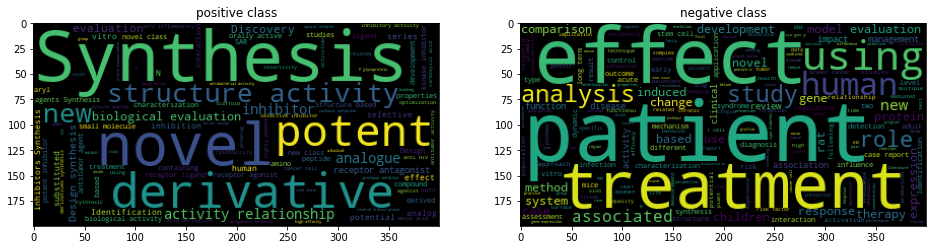

In [10]:
# next let's take a look at the titles to see if there is any clear difference between 
# the 2 classes 
cloud_pos = wc.WordCloud().generate(' '.join(df[df.tag=='1'].title))
cloud_neg = wc.WordCloud().generate(' '.join(df[df.tag=='-1'].title))
plt.figure(figsize=(16,8))
ax = plt.subplot(1,2,1)
ax.title.set_text('positive class')
plt.imshow(cloud_pos)
ax = plt.subplot(1,2,2)
plt.imshow(cloud_neg)
ax.title.set_text('negative class')

### Initial sparse baslines

In [29]:
# we decided to have a very simple pre-processing pipline consisting of numerals 
# substitution, punctuation substitution and lower-casing for 2 reasons:
# 1- any more aggressive steps can miss up the chemichal compunds names 
# 2- our initial attempts to locate the compunds using automated tools like 
# ChemDataExtractor and execluding them from the pre-processing was unseccessful as the 
# tool missed many of the components we tried 

def pre_process(text):
    text = text.lower()
    text = re.sub('\d+', ' N ', text)
    text = re.sub('[^\w^\s]+', ' P ', text)
    text = re.sub('\s+', ' ', text)
    return text

def train_shallow(x_train, x_val, x_test, y_train, y_val, y_test ):
# first we perpare the pre-defined held-out validation set 
    X = vstack((x_title_train, x_title_val))
    Y = np.concatenate([y_train, y_val])
    pds = np.concatenate([-1 * np.ones((x_train.shape[0], 1)), np.zeros((x_val.shape[0], 1))])
    pds = PredefinedSplit(test_fold = pds)
    
#     here we set the weight to balanced to help with the class imbalamce issue
    model_family = svm.SVC(tol=1e-2, random_state=0, class_weight='balanced')
    parameters = dict(C=uniform(loc=0, scale=4),
                         kernel=['linear', 'poly', 'rbf','sigmoid'],
                         degree = [1,2,3,4],)
    model_clf = RandomizedSearchCV(model_family, parameters, random_state=0, cv=pds)
    
    # ------------------------------training------------------------------------------
    print('training')
    clf = model_clf.fit(X, Y)
    print(model_clf.best_params_)
    # ------------------------------predicting------------------------------------------
    print('predicting')
    h_train = clf.predict(x_train)
    h_val = clf.predict(x_val)
    h_test = clf.predict(x_test)
    # ------------------------------Report Results------------------------------------
    target_names = ['positive', 'negative']
    print('training preformance')
    print(metrics.classification_report(y_train, h_train, target_names=target_names))

    print('validation preformance')
    print(metrics.classification_report(y_val, h_val, target_names=target_names))

    print('testing preformance')
    print(metrics.classification_report(y_test, h_test, target_names=target_names))

    metrics.plot_confusion_matrix(clf, x_test, y_test)  
    plt.show()

In [12]:
df.abstact = df.abstact.apply(pre_process)
df.title = df.title.apply(pre_process)
df.mesh = df.mesh.apply(pre_process)

In [13]:
# splitting data into train, val and test
# first shuffle 
df = df.sample(frac=1)
# then split
train_thres = int(len(df)*0.85)
val_thres = int(len(df)*0.95)
train = df[:train_thres]
val = df[train_thres:val_thres]
test = df[val_thres:]

In [31]:
# here we decided to treat each of the different feature as a full different vocabulary 
#  and then we can see which is the most important feature and if thier combinations 
#  is usefull

# we couldn't apply PCA simply because of the size of the vocabulary 
# (especially with the abstracts) that is why we are directly using chi2 


pipe = Pipeline([('vectorizer', TfidfVectorizer(ngram_range=(1, 2), 
                                                stop_words='english', 
                                                max_df=0.95,min_df = 5)),
                 ('selector', SelectKBest(chi2, k=10000))
                ])

# get the targets
y_train = train.tag
y_val = val.tag
y_test = test.tag

# fit on training set
x_title_train = pipe.fit_transform(train.title.to_list(), y_train)

# use for validation/test sets
x_title_val = pipe.transform(val.title.to_list())
x_title_test = pipe.transform(test.title.to_list())


# ======== and another vectorizer for the mesh
# here we tried to be as careful as possible to keep all the chemical components that 
#  is why the min_df is so low 
pipe = Pipeline([('vectorizer', TfidfVectorizer(ngram_range=(1, 2), 
                                                stop_words='english', 
                                                max_df=0.95,min_df = 5)),
                 ('selector', SelectKBest(chi2, k=10000))
                ])
# fit on training set
x_mesh_train = pipe.fit_transform(train.mesh.to_list(), y_train)

# use for validation/test sets
x_mesh_val = pipe.transform(val.mesh.to_list())
x_mesh_test = pipe.transform(test.mesh.to_list())


# ======== another vectorizer for the abstracts

# here I execlude the examples with empty abstracts
train = train[train.abstact.apply(bool)]
val = val[val.abstact.apply(bool)]
test = test[test.abstact.apply(bool)]

# get the targets
y_abs_train = train.tag
y_abs_val = val.tag
y_abs_test = test.tag

pipe = Pipeline([('vectorizer', TfidfVectorizer(ngram_range=(1, 2), 
                                                stop_words='english', 
                                                max_df=0.95,min_df = 5)),
                 ('selector', SelectKBest(chi2, k=100000))
                ])

# fit on training set
x_abstracts_train = pipe.fit_transform(train.abstact.to_list(), y_train)

# use for validation/test sets
x_abstracts_val = pipe.transform(val.abstact.to_list())
x_abstracts_test = pipe.transform(test.abstact.to_list())


titles only model
training
{'C': 1.6946191973556188, 'degree': 2, 'kernel': 'rbf'}
predicting
training preformance
              precision    recall  f1-score   support

    positive       0.99      0.98      0.98     54465
    negative       0.97      0.98      0.98     39948

    accuracy                           0.98     94413
   macro avg       0.98      0.98      0.98     94413
weighted avg       0.98      0.98      0.98     94413

validation preformance
              precision    recall  f1-score   support

    positive       0.99      0.98      0.99      6512
    negative       0.97      0.98      0.98      4528

    accuracy                           0.98     11040
   macro avg       0.98      0.98      0.98     11040
weighted avg       0.98      0.98      0.98     11040

testing preformance
              precision    recall  f1-score   support

    positive       0.96      0.96      0.96      3201
    negative       0.94      0.94      0.94      2335

    accuracy            

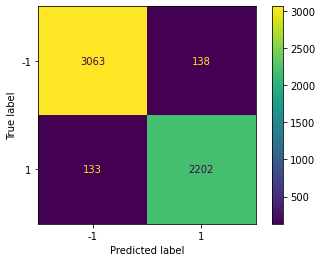

In [32]:
# training on titles only 
print('titles only model')
train_shallow(x_title_train, x_title_val, x_title_test, y_train, y_val, y_test )

titles only model
training
{'C': 1.6946191973556188, 'degree': 2, 'kernel': 'rbf'}
predicting
training preformance
              precision    recall  f1-score   support

    positive       0.61      0.85      0.71     54465
    negative       0.56      0.26      0.36     39948

    accuracy                           0.60     94413
   macro avg       0.59      0.56      0.53     94413
weighted avg       0.59      0.60      0.56     94413

validation preformance
              precision    recall  f1-score   support

    positive       0.62      0.85      0.72      6512
    negative       0.54      0.26      0.35      4528

    accuracy                           0.61     11040
   macro avg       0.58      0.55      0.53     11040
weighted avg       0.59      0.61      0.57     11040

testing preformance
              precision    recall  f1-score   support

    positive       0.61      0.85      0.71      3201
    negative       0.55      0.26      0.35      2335

    accuracy            

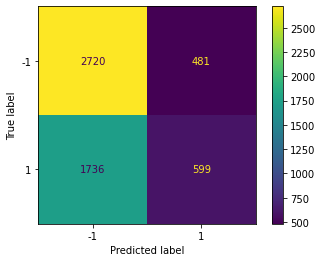

In [33]:
# training on the mesh only 
print('titles only model')
train_shallow(x_mesh_train, x_mesh_val, x_mesh_test, y_train, y_val, y_test )

titles only model
training
{'C': 1.6946191973556188, 'degree': 2, 'kernel': 'rbf'}
predicting
training preformance
              precision    recall  f1-score   support

    positive       0.61      0.85      0.71     54465
    negative       0.56      0.26      0.36     39948

    accuracy                           0.60     94413
   macro avg       0.59      0.56      0.53     94413
weighted avg       0.59      0.60      0.56     94413

validation preformance
              precision    recall  f1-score   support

    positive       0.62      0.85      0.72      6512
    negative       0.54      0.26      0.35      4528

    accuracy                           0.61     11040
   macro avg       0.58      0.55      0.53     11040
weighted avg       0.59      0.61      0.57     11040

testing preformance
              precision    recall  f1-score   support

    positive       0.61      0.85      0.71      3201
    negative       0.55      0.26      0.35      2335

    accuracy            

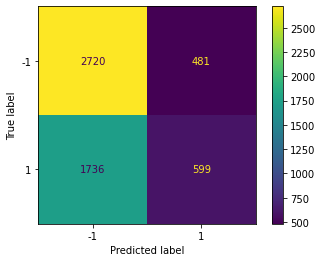

In [34]:
# training on the abstracts only 
print('titles only model')
train_shallow(x_mesh_train, x_mesh_val, x_mesh_test, y_train, y_val, y_test )